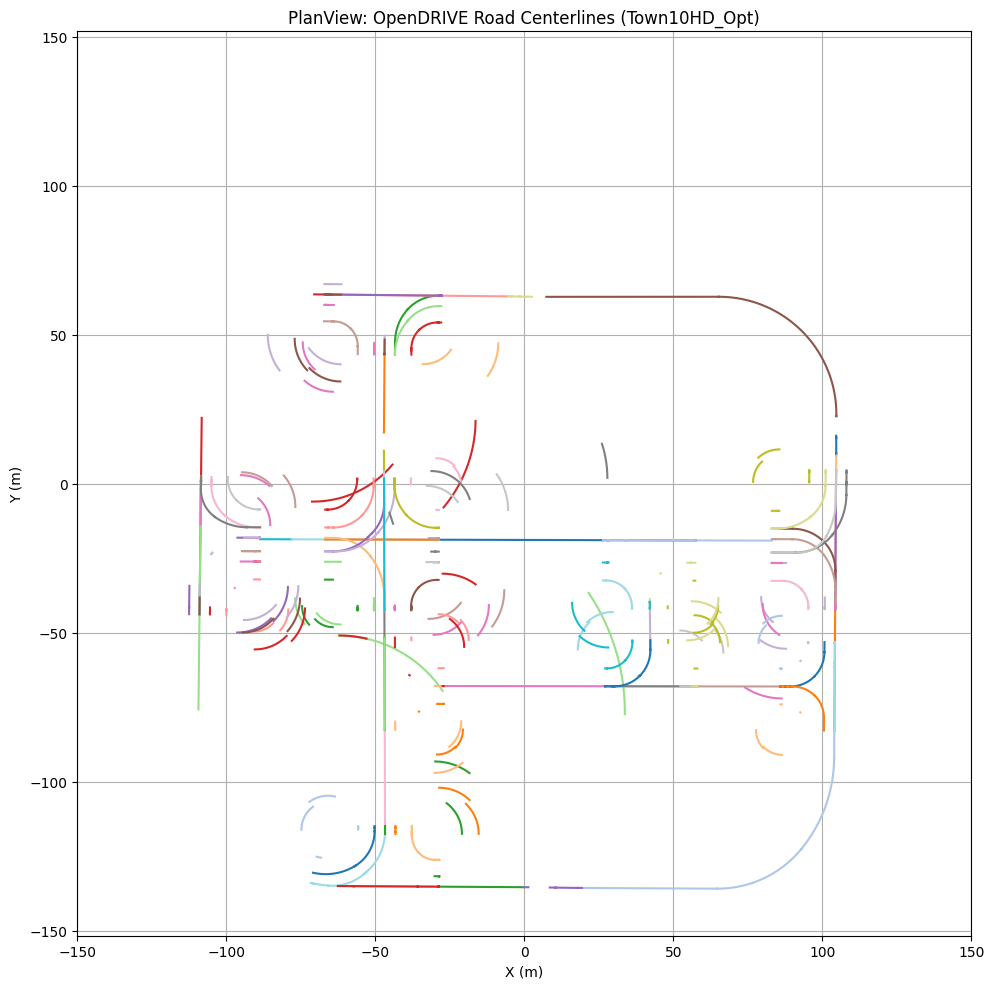

In [5]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np

# Use the uploaded file
file_path = "../data/Town10HD_Opt.xodr"
tree = ET.parse(file_path)
root = tree.getroot()

def sample_geometry(x0, y0, hdg, length, geom_type='line', params=None, n_pts=50):
    """
    Returns (x_vals, y_vals) for a straight line or an arc geometry.
    Extend with spirals if needed.
    """
    x_vals, y_vals = [], []
    s_array = np.linspace(0, length, n_pts)

    if geom_type == 'arc' and params is not None:
        curvature = float(params.get('curvature', 0))
        if curvature != 0:
            radius = 1.0 / curvature
            # Compute center of the arc:
            center_x = x0 - np.sin(hdg) * radius
            center_y = y0 + np.cos(hdg) * radius
            start_angle = np.arctan2(y0 - center_y, x0 - center_x)
            dtheta = length / radius
            angles = np.linspace(start_angle, start_angle + dtheta, n_pts)
            for angle in angles:
                x_vals.append(center_x + radius * np.cos(angle))
                y_vals.append(center_y + radius * np.sin(angle))
            return x_vals, y_vals

    # Default: treat as a straight line
    for s in s_array:
        x = x0 + s * np.cos(hdg)
        y = y0 + s * np.sin(hdg)
        x_vals.append(x)
        y_vals.append(y)
    return x_vals, y_vals

# Create the plot
plt.figure(figsize=(10, 10))
plt.title("PlanView: OpenDRIVE Road Centerlines (Town10HD_Opt)")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.axis('equal')
plt.grid(True)


colors = plt.cm.tab20(np.linspace(0, 1, 20))
roads = root.findall('.//road')
for i, road in enumerate(roads):
    plan_view = road.find('planView')
    if plan_view is None:
        continue
    # We'll collect all geometry segments in one continuous set,
    # separating segments with NaN so they don't connect.
    road_x, road_y = [], []
    for geometry in plan_view.findall('geometry'):
        x0 = float(geometry.get('x', '0'))
        y0 = float(geometry.get('y', '0'))
        hdg = float(geometry.get('hdg', '0'))
        length = float(geometry.get('length', '0'))
        gtype = 'line'
        params = {}
        for child in geometry:
            if child.tag in ['line', 'arc']:
                gtype = child.tag
                params = child.attrib
                break
            x_vals, y_vals = sample_geometry(x0, y0, hdg, length, gtype, params)
            if road_x:  # add gap between consecutive segments
                road_x.append(np.nan)
                road_y.append(np.nan)
            road_x.extend(x_vals)
            road_y.extend(y_vals)
        x_vals, y_vals = sample_geometry(x0, y0, hdg, length, gtype, params)
        if road_x:  # add gap between consecutive segments
            road_x.append(np.nan)
            road_y.append(np.nan)
        road_x.extend(x_vals)
        road_y.extend(y_vals)
    color = colors[i % 20]
    plt.plot(road_x, road_y, color=color)

plt.tight_layout()
plt.xlim(-150, 150)
plt.ylim(-150, 150)
plt.show()
